In [327]:
import cv2
import numpy as np
import os

from google.colab import files
from google.colab.patches import cv2_imshow

In [394]:
# Загрузка видео в Colab
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print("Загружено видео:", video_path)

Saving mona-lisa.avi to mona-lisa (8).avi
Загружено видео: mona-lisa (8).avi


### Получение первого кадра

Размер первого кадра: (360, 640, 3)


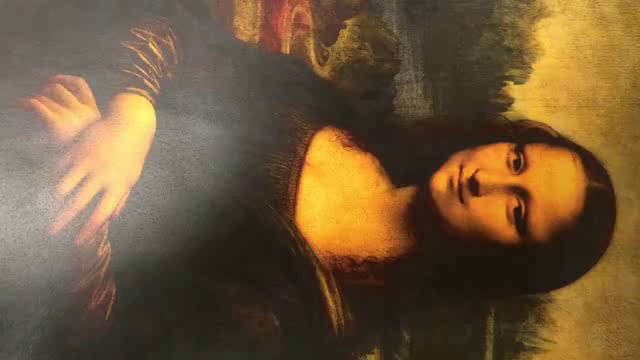

In [395]:
def get_first_frame(video_path: str):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    return frame

first_frame = get_first_frame(video_path)
print("Размер первого кадра:", first_frame.shape)
cv2_imshow(first_frame)


### Инициализация ключевых точек (goodFeaturesToTrack)

Начальное количество точек: 222


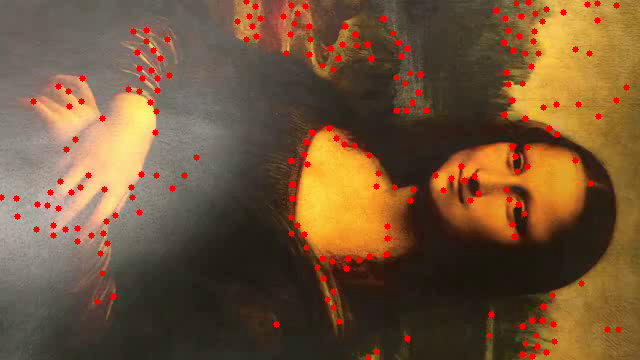

In [397]:
# Параметры для поиска ключевых точек (Shi-Tomasi corner detector)
feature_params = dict(
    maxCorners = 500,      # максимальное число точек
    qualityLevel = 0.05,   # минимальное качество
    minDistance = 10,       # минимальное расстояние между точками
    blockSize = 7
)

def detect_initial_points(frame_bgr, feature_params):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
    return gray, p0

prev_gray, p0 = detect_initial_points(first_frame, feature_params)
print("Начальное количество точек:", 0 if p0 is None else len(p0))

# Визуализируем найденные точки на первом кадре
vis = first_frame.copy()
if p0 is not None:
    for pt in p0:
        x, y = pt.ravel()
        cv2.circle(vis, (int(x), int(y)), 3, (0, 0, 255), -1)
cv2_imshow(vis)

### Параметры оптического потока (Lucas–Kanade)

In [377]:
# Параметры Lucas–Kanade (пирамидальный оптический поток)
lk_params = dict(
    winSize  = (15, 15),      # окно поиска
    maxLevel = 3,             # число уровней пирамиды
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)


### Основная функция обработки видео с оптическим потоком

In [382]:
def process_video_optical_flow(
    video_path,
    output_path,
    feature_params,
    lk_params,
    homography_ransac_thresh = 3,
    min_inliers_for_H = 15,
    blur_thresh = 10,
    draw_points = True
):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 0:
        fps = 25.0
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    # первый кадр
    ret, frame0 = cap.read()

    gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(gray0, mask=None, **feature_params)

    # стартовая рамка по точкам
    pts0 = p0.reshape(-1, 2).astype(np.float32)
    rect0 = cv2.minAreaRect(pts0) # минимальный по площади вращающийся прямоугольник, покрывающий точки
    box0 = cv2.boxPoints(rect0).astype(np.float32)
    box_curr = box0.reshape(-1, 1, 2).copy()

    old_gray = gray0.copy() # относительно него считаем оптический поток

    frame_idx = 1
    blur_frames = 0
    h_updates = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # проверка на blur
        if cv2.Laplacian(gray, cv2.CV_64F).var() < blur_thresh:
            blur_frames += 1
            out.write(frame)
            frame_idx += 1
            continue

        # оптический поток
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, p0, None, **lk_params)
        if p1 is None or st is None:
            out.write(frame)
            frame_idx += 1
            continue

        # отбираем только успешно протреченные точки
        st = st.reshape(-1)
        p0_good = p0[st == 1]
        p1_good = p1[st == 1]

        # оценка гомографии для обновления рамки
        if len(p1_good) >= 8:
            src = p0_good.reshape(-1, 2).astype(np.float32)
            dst = p1_good.reshape(-1, 2).astype(np.float32)

            H, inl = cv2.findHomography(src, dst, cv2.RANSAC, homography_ransac_thresh)
            inliers = 0 if inl is None else int(inl.sum())

            if H is not None and inliers >= min_inliers_for_H:
                # perspectiveTransform применяет 3x3 H к вершинам рамки и переносит рамку на новый кадр с учётом перспективы
                box_curr = cv2.perspectiveTransform(box_curr, H)
                h_updates += 1

        # визуализация
        vis = frame.copy()

        if draw_points:
            pts = p1_good.reshape(-1, 2)
            for x, y in pts:
                cv2.circle(vis, (int(x), int(y)), 2, (0, 0, 255), -1)

        cv2.polylines(vis, [box_curr.reshape(-1, 2).astype(np.int32)], True, (0, 255, 0), 2)
        out.write(vis)

        # обновляем состояния
        old_gray = gray
        p0 = p1_good.reshape(-1, 1, 2).astype(np.float32)

        frame_idx += 1
        if frame_idx % 30 == 0:
            print(f"Кадр {frame_idx}, blur={blur_frames}, H_updates={h_updates}, pts={len(p0)}")

    cap.release()
    out.release()
    print(f"Всего кадров: {frame_idx}, blur кадров: {blur_frames}, обновлений H: {h_updates}")

### Запуск трекинга и скачивание результата

In [396]:
output_video_path = "tracked_" + os.path.basename(video_path)

process_video_optical_flow(
    video_path=video_path,
    output_path=output_video_path,
    feature_params=feature_params,
    lk_params=lk_params
)

files.download(output_video_path)

Кадр 30, blur=0, H_updates=29, pts=222
Кадр 60, blur=0, H_updates=59, pts=222
Кадр 90, blur=0, H_updates=89, pts=222
Кадр 120, blur=0, H_updates=119, pts=222
Кадр 150, blur=0, H_updates=149, pts=222
Кадр 180, blur=0, H_updates=179, pts=222
Кадр 210, blur=0, H_updates=209, pts=222
Кадр 240, blur=0, H_updates=239, pts=222
Кадр 270, blur=0, H_updates=269, pts=222
Кадр 300, blur=0, H_updates=299, pts=222
Кадр 330, blur=0, H_updates=329, pts=222
Кадр 360, blur=0, H_updates=359, pts=222
Кадр 390, blur=0, H_updates=389, pts=222
Кадр 420, blur=0, H_updates=419, pts=222
Кадр 450, blur=0, H_updates=449, pts=222
Кадр 480, blur=0, H_updates=479, pts=217
Кадр 510, blur=0, H_updates=509, pts=217
Кадр 540, blur=0, H_updates=539, pts=217
Всего кадров: 558, blur кадров: 0, обновлений H: 557


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>